**ตัวอย่างการทำ Sentiment Analysis**

Input คือ ประโยค (Inputs)

Output คือ การจำแนก Label แบบ Multiclass (Multinomial Classification)

ขั้นตอน preprocess: แบ่งคำ (Tokenization) แปลงให้เป็นตัวเลข (Word Representation)


Train ด้วย NN และวัดผล (Test/Evaluate) แล้วนำไปใช้

credit: https://sysadmin.psu.ac.th/2019/01/15/python-06-sentiment-analysis-with-keras-tensorflow/

Input
แบ่งเป็น Positive, Neutral, Negative
เอามารวมกันเป็น data โดยแปลงเป็น Numpy Array เพื่อสะดวกในการ Tokenization ต่อไป

In [1]:
labels = {0:"Negative", 1:"Neutral", 2:"Positive"}
negative = [
    ["I hate it", 0],
    ["I don't like it so much", 0],
    ["No good at all", 0]
]
neutral = [
    ["So so", 1],
    ["No bad no good", 1],
    ["Feel nothing", 1]
]
positive = [
    ["I love it", 2],
    ["I like it so much", 2],
    ["No one can overcome", 2]
]

In [2]:
import numpy as np
data = np.array( negative + neutral + positive)
data

array([['I hate it', '0'],
       ["I don't like it so much", '0'],
       ['No good at all', '0'],
       ['So so', '1'],
       ['No bad no good', '1'],
       ['Feel nothing', '1'],
       ['I love it', '2'],
       ['I like it so much', '2'],
       ['No one can overcome', '2']], dtype='<U23')

**Tokenization**

Keras มีเครื่องมือให้แล้ว คือ Tokenizer ใน Keras Text Preprocessing

fit_on_texts ทำหน้าที่ แปลงข้อมูล “หลาย ๆ ประโยค” จาก data ในคอลัมน์ 0 ให้เป็นคำ ๆ โดยแยกคำด้วย “เว้นวรรค” และกำหนด Index ให้แต่ละคำ (word_index) โดย “เรียงตามความถี่” จะสังเกตุว่า คำว่า i , it อยู่อันดับ 1, 2 ตามลำดับ (และจะเห็นว่า มีการแปลงเป็น lower ทั้งหมด)

In [4]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data[:,0])
tokenizer.word_index

{'i': 1,
 'it': 2,
 'so': 3,
 'no': 4,
 'like': 5,
 'much': 6,
 'good': 7,
 'hate': 8,
 "don't": 9,
 'at': 10,
 'all': 11,
 'bad': 12,
 'feel': 13,
 'nothing': 14,
 'love': 15,
 'one': 16,
 'can': 17,
 'overcome': 18}

One-hot Encode สำหรับค่า labels
keras มี to_categorical method ทำหน้าที่เปลี่ยน Integer เป็น One-hot Encode ดังตัวอย่างด้านล่าง ในการแปลงกลับ ใช้ argmax method ของ Numpy

In [5]:
from tensorflow.keras.utils import to_categorical
print("Unique lables = " , set(data[:,1]))
y=to_categorical([ int(i) for i in data[:,1]])
print(y)
print(y[0], "=>", np.argmax(y[0]))
print(y[3], "=>", np.argmax(y[3]))
print(y[7], "=>", np.argmax(y[7]))

Unique lables =  {'0', '1', '2'}
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[1. 0. 0.] => 0
[0. 1. 0.] => 1
[0. 0. 1.] => 2


เตรียมประโยค ให้เป็น Sequence ที่มีความยาวเท่ากัน

การนำข้อมูลเข้าสู่ NN ต้องเตรียม Array ที่มีขนาดเท่า ๆ กัน ดังตัวอย่าง
ในที่นี้ใช้ texts_to_sequences แปลง ประโยค ให้เป็น Sequence (Array of Integer)

จากนั้น หาความยาวของประโยค และหาค่าสูงสูด (maxlen) — มีทั้งข้อดีข้อเสีย
แล้ว เติมเต็ม (Padding) ให้ทุกประโยค มีความยาวเท่ากัน โดยเติม 0 ข้างท้าย (padding=’post’)

In [6]:
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
tts = tokenizer.texts_to_sequences(data[:,0])
print("Raw Texts to Sequence:")
for s in tts: print(s)
maxlen = max([len(s) for s in tts])
print("max sentense's length = " , maxlen)
x = pad_sequences(tts, maxlen=maxlen, padding="post")
print("Sequence Padding at maxlen words, post padding:\n", x)

Raw Texts to Sequence:
[1, 8, 2]
[1, 9, 5, 2, 3, 6]
[4, 7, 10, 11]
[3, 3]
[4, 12, 4, 7]
[13, 14]
[1, 15, 2]
[1, 5, 2, 3, 6]
[4, 16, 17, 18]
max sentense's length =  6
Sequence Padding at maxlen words, post padding:
 [[ 1  8  2  0  0  0]
 [ 1  9  5  2  3  6]
 [ 4  7 10 11  0  0]
 [ 3  3  0  0  0  0]
 [ 4 12  4  7  0  0]
 [13 14  0  0  0  0]
 [ 1 15  2  0  0  0]
 [ 1  5  2  3  6  0]
 [ 4 16 17 18  0  0]]


**Word Embeding**

Word Embedding เป็น “หนึ่งในหลายวิธี” ของการแปลง คำ เป็น เวคเตอร์ของจำนวนจริง (vector of real number) จะเห็นได้ว่าตัวแปร x ข้างต้น เป็นจำนวนเต็ม (Integer) มีมิติเดียว

ส่วน Word Embedding จะแปลง คำ เป็นเวคเตอร์หลายมิติตามต้องการ (output_dim) โดยคำนวนจาก input_dim = จำนวนคำทั้งหมด (vocab_size) และ input_length = ความยาวของประโยคสูงสุด (maxlen)

ตัวอย่างต่อไปนี้ แปลง x จำนวน 9 ประโยค เป็น Word Embedding ซึ่งกำหนด input_dim = vocab_size, input_length = maxlen (ในที่นี้คือ 6) และ ต้องการแสดง Word Embedding เป็น Vector 2 มิติ (output_dim=2)

In [7]:
from keras.models import Sequential
from keras.layers import Embedding

vocab_size = len(tokenizer.word_index) +1

# Fix Random Weight
# For reproducable
np.random.seed(7)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=2,
                    input_length=maxlen))

model.compile(loss='categorical_crossentropy', optimizer='adam')
y_predict = model.predict(x)

print("y_predict shape:\n", y_predict.shape)
print(y_predict[0])
print(min(y_predict[0][0]))
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
y_predict shape:
 (9, 6, 2)
[[-0.01803314 -0.02024654]
 [ 0.00216381 -0.01403624]
 [-0.02979536 -0.02227757]
 [-0.01833316 -0.02543149]
 [-0.01833316 -0.02543149]
 [-0.01833316 -0.02543149]]
-0.020246541


/Users/sirisuk/anaconda3/envs/nlp_py3.9/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (9, 6, 2)              │            38 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38 (152.00 B)

 Trainable params: 38 (152.00 B)

 Non-trainable params: 0 (0.00 B)

จะเห็นได้ว่า ผลจาก Word Embedding จะได้ Array ขนาด 9 x 6 x 2 นั่นคือ ได้ เวคเตอร์ของแต่ละคำมี 2 มิติ แต่ละประโยคมี 6 คำ และ มีทั้งหมด 9 ประโยค (ตัวอย่างข้างต้น แสดงตัวอย่างแรก คือ จาก [ 1 8 2 0 0 0] )

ลองเปลี่ยน output_dim = 16

วิธีการนี้ ทำให้สามารถคำนวณว่า คำใด มีความสัมพันธ์กันขนาดใดได้ เช่น king – man + woman = ?? ซึ่งมนุษย์เราจะตอบว่า queen เป็นต้น

In [8]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

ลองใช้ Flattern และ Dense
จาก [python #03 – Train/Validation/Test and Accuracy Assessment with Confusion Matrix](https://sysadmin.psu.ac.th/2019/01/07/python-03-train-validation-test-and-accuracy-assessment-with-confusion-matrix/) ได้กล่าวถึง Layer แบบ Fully-Connected หรือที่เรียกว่า Dense มาแล้ว ตอนนี้จะเอามาต่อกับ Embedding Layer แต่ เนื่องจาก Dimension ที่ออกจาก Embedding Layer เป็นแบบ 3D จึงต้องนำมาแผ่ หรือที่เรียกว่า Flattern ก่อน

/Users/sirisuk/anaconda3/envs/nlp_py3.9/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - categorical_accuracy: 0.4444 - loss: nan
Epoch 2/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.3333 - loss: nan
Epoch 3/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.3333 - loss: nan
Epoch 4/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3333 - loss: nan
Epoch 5/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.3333 - loss: nan
Epoch 6/6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.3333 - loss: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Normalized confusion matrix
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


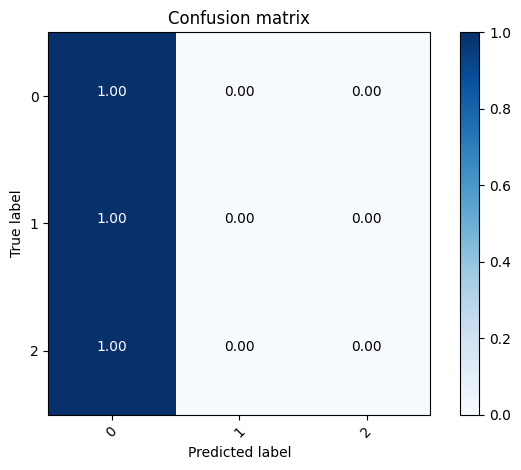

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from sklearn.metrics import confusion_matrix

vocab_size = len(tokenizer.word_index) +1

# Fix Random Weight
# For reproducable
np.random.seed(7)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=10,
                    input_length=maxlen))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(3, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

model.fit(x,y, epochs=6)

y_predict = model.predict(x)

y_t=[ np.argmax(i) for i in y]
y_p=[ np.argmax(i) for i in y_predict]

cm=confusion_matrix(y_t, y_p)
plot_confusion_matrix(cm=cm, classes=['0','1','2'], normalize=True)

LSTM – Long Short-Term Memory
ในการทำงานด้าน NLP มี Layer อีกประเภทที่เรียกว่า Recurrent Neural Network (RNN) ซึ่งเหมาะสำหรับงานที่มีลำดับเวลา เช่น ประโยคคำพูดเป็นต้น แต่ RNN พื้นฐานมีปัญหากับการ Train ข้อมูลที่มีความยาวมาก ๆ จึงมีการพัฒนา LSTM และ GRU ขึ้นมา

ทดลองนำ LSTM มาแทน Flattern และ Dense

/Users/sirisuk/anaconda3/envs/nlp_py3.9/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step - accuracy: 0.3333 - loss: 1.0990
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3333 - loss: 1.0983
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4444 - loss: 1.0976
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4444 - loss: 1.0968
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5556 - loss: 1.0958
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4444 - loss: 1.0950
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5556 - loss: 1.0941
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5556 - loss: 1.0931
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5556 - loss: 1.0920
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5556 - loss: 1.0911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Normalized confusion matrix
[[0.         0.33333333 0.66666667]
 [0.         0.66666667 0.33333333]
 [0.         0.         1.    

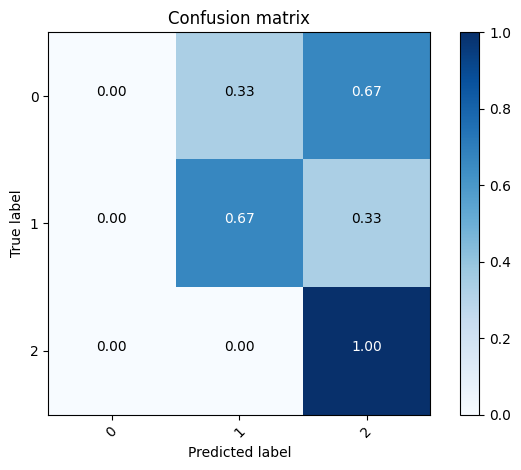

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional
from sklearn.metrics import confusion_matrix

vocab_size = len(tokenizer.word_index) +1

# Fix Random Weight
# For reproducable
np.random.seed(7)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=10,
                    input_length=maxlen))
#model.add(Flatten())
#model.add(Dense(20, activation='relu'))

model.add(LSTM(20))
#model.add(Bidirectional(LSTM(16)))
model.add(Dense(3, activation='relu'))

# Add an output layer
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(x,y, epochs=10)

y_predict = model.predict(x)

y_t=[ np.argmax(i) for i in y]
y_p=[ np.argmax(i) for i in y_predict]

cm=confusion_matrix(y_t, y_p)
plot_confusion_matrix(cm=cm, classes=['0','1','2'], normalize=True)

ทดสอบการใช้งาน
สร้างข้อมูลทดสอบ โดยประกอบไปด้วย คำที่โมเดลเคยเจอ และคำที่ไม่อยู่ใน Dictionary ซึ่งจะถูกแทนด้วย 0 ตามนี้

In [11]:
test=[
    ['I do love it',2],
    ['we do love it',2],
    ['Wow! it is great!',2],
    ['I have no idea',1],
    ['so so',1],
    ['no idea',1],
    ['totally worst',0],
    ['bad movie',0],
    ['god damn!',0],
]
data_test = np.array(test)
x_data_test = data_test[:,0]
y_data_test = data_test[:,1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4444 - loss: 1.0978
Normalized confusion matrix
[[0.         1.         0.        ]
 [0.         0.66666667 0.33333333]
 [0.         0.33333333 0.66666667]]


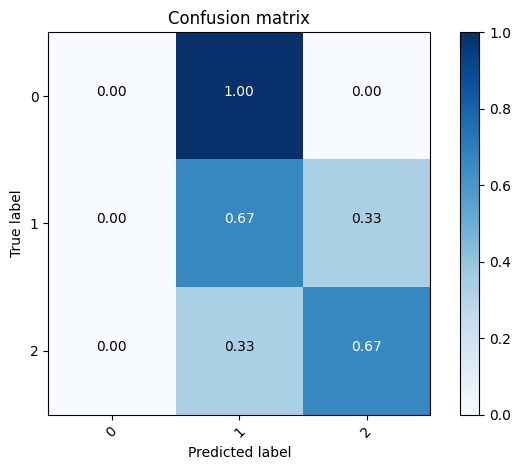

In [13]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence
x_test=[]
for t in x_data_test:
    s = []
    for w in text_to_word_sequence(t):
        if w in tokenizer.word_index:
            s.append(tokenizer.word_index[w])
        else:
            s.append(0)
    x_test.append(s)
x_test=pad_sequences(x_test,maxlen=maxlen,padding='post')
y_test=to_categorical(y_data_test)

y_predict = model.predict(x_test)

y_t=[ np.argmax(i) for i in y_test]
y_p=[ np.argmax(i) for i in y_predict]

acc = model.evaluate(x_test, y_test)
cm=confusion_matrix(y_t, y_p)
plot_confusion_matrix(cm=cm, classes=['0','1','2'], normalize=True)

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

precision_score(y_t, y_p, average=None)

/Users/sirisuk/anaconda3/envs/nlp_py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([0.        , 0.33333333, 0.66666667])